Author: Chris J. Dallmann \
Affiliation: University of Wuerzburg \
Last revision: 04-January-2026

In [8]:
# Import libraries
import pandas as pd
import numpy as np 
from caveclient import CAVEclient
import matplotlib.pyplot as plt

import cloudvolume 
from meshparty import trimesh_io, trimesh_vtk 
from meshparty import meshwork
from meshparty import skeletonize, skeleton_io, skeleton

In [2]:
# Set parameters 
root_id = 720575940639781027
syn_thresh = 5
neuron_color = [0, 174/255, 239/255]
pre_color = [1,153/255,0]
post_color = [191/255,0,191/255]

In [3]:
# Access dataset
client = CAVEclient()
dataset = 'flywire_fafb_public'
client = CAVEclient(dataset)
client.materialize.version = 783

In [4]:
# Get synapse coordinates 

# Get synapse dataframe
df_pre = client.materialize.query_view("valid_synapses_nt_np", filter_in_dict={"post_pt_root_id": [root_id]})
df_post = client.materialize.query_view("valid_synapses_nt_np", filter_in_dict={"pre_pt_root_id": [root_id]})

# Add synapse count
df_pre['syn_count'] = 1
df_post['syn_count'] = 1

# Get IDs of partner neurons that make connections >= syn_thresh  
df_pre_summed = df_pre
df_post_summed = df_post

df_pre_summed = df_pre_summed.groupby(['pre_pt_root_id','post_pt_root_id'])['syn_count'].sum().reset_index().sort_values('syn_count', ascending=False)
df_post_summed = df_post_summed.groupby(['pre_pt_root_id','post_pt_root_id'])['syn_count'].sum().reset_index().sort_values('syn_count', ascending=False)

df_pre_summed = df_pre_summed[df_pre_summed.syn_count>=syn_thresh]
df_post_summed = df_post_summed[df_post_summed.syn_count>=syn_thresh]

pre_ids_to_include = df_pre_summed.pre_pt_root_id.tolist()
post_ids_to_include = df_post_summed.post_pt_root_id.tolist()

# Trim synapse dataframe
df_pre = df_pre[df_pre.pre_pt_root_id.isin(pre_ids_to_include)]
df_post = df_post[df_post.post_pt_root_id.isin(post_ids_to_include)]

# Get synapse positions (in nm)
pre_syn_pos = np.vstack(df_pre.post_pt_position)
post_syn_pos = np.vstack(df_post.pre_pt_position)

Query was executed using streaming via CSV, which can mangle types. Please upgrade to caveclient > 8.0.0 to avoid type mangling. Because you may have been affected by mangled types, this change is breaking, but it should provide an improved experience.
Query was executed using streaming via CSV, which can mangle types. Please upgrade to caveclient > 8.0.0 to avoid type mangling. Because you may have been affected by mangled types, this change is breaking, but it should provide an improved experience.


In [5]:
# Get neuron mesh
seg_path = "precomputed://gs://flywire_v141_m783"
cv_seg = cloudvolume.CloudVolume(seg_path, use_https=True, mip=2)

In [6]:
# Generate mesh
seg_source = client.info.segmentation_source()
mm = trimesh_io.MeshMeta(cv_path=seg_source, disk_cache_path='../meshes', map_gs_to_https=True)
neuron_mesh = mm.mesh(seg_id=root_id, remove_duplicate_vertices=True, merge_large_components=False)

# Convert mesh object to a meshwork object
neuron_mesh_mw = meshwork.Meshwork(neuron_mesh, seg_id=root_id) #, voxel_resolution=[4.3,4.3,45])

# Generate skeleton 
neuron_mesh_mw.skeletonize_mesh()

# Get vertices
neuron_pos = np.asarray(neuron_mesh_mw.vertices) 

C:\Users\Chris\anaconda3\envs\flywire\lib\site-packages\meshparty\skeletonize.py:622: RuntimeWarning: invalid value encountered in multiply
  target = np.nanargmax(root_ds * valid)


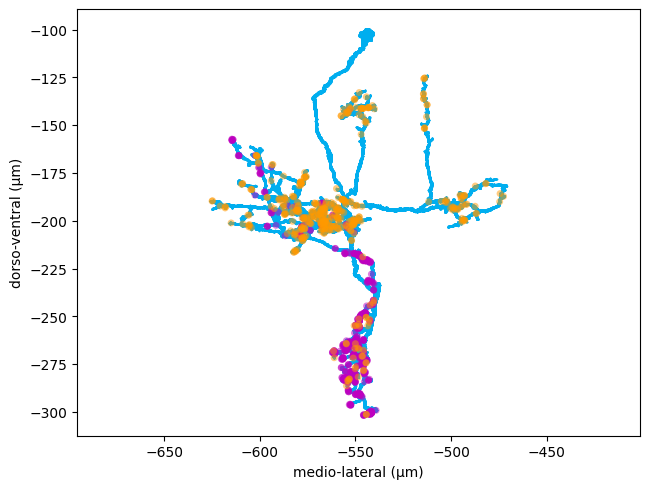

In [7]:
# Plot mesh and synapses in µm (posterior view)
fig, ax = plt.subplots()
ax.scatter(-neuron_pos[:,0]/1000, -neuron_pos[:,1]/1000, .1, color=neuron_color)
ax.scatter(-post_syn_pos[:,0]/1000, -post_syn_pos[:,1]/1000, s=100, alpha=0.5, color=post_color, marker='.', edgecolors='none')
ax.scatter(-pre_syn_pos[:,0]/1000, -pre_syn_pos[:,1]/1000, s=100, alpha=0.5, color=pre_color, marker='.', edgecolors='none')
plt.tight_layout()
ax.axis('equal')
plt.xlabel('medio-lateral (µm)')
plt.ylabel('dorso-ventral (µm)')
#plt.savefig(r'C:/Users/Chris/Desktop/figure.png', dpi=400, transparent=True)
plt.show()